# Some Notes
https://www.kaggle.com/hexietufts/easy-to-use-keras-imagedatagenerator
http://machinelearningmastery.com/image-augmentation-deep-learning-keras/

In [3]:
import numpy as np
import pandas as pd
import os
from glob import glob
import cv2
from sklearn.model_selection import train_test_split
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = "data/train/"
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'gif'
        data_path = "data/train_masks/"
        suffix = '_mask'
    elif "Test" in image_type:
        ext = 'jpg'
        data_path = "data/test"
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))

# get_filename("0cdf5b5d0ce1_01", "Test")

In [5]:
import cv2
from PIL import Image

# taken from kaggle data analysis kernel 
def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)

    img = np.asarray(img_pil)
    print(img.shape)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

(1280, 1918, 3)
(1280, 1918)
(1280, 1918)


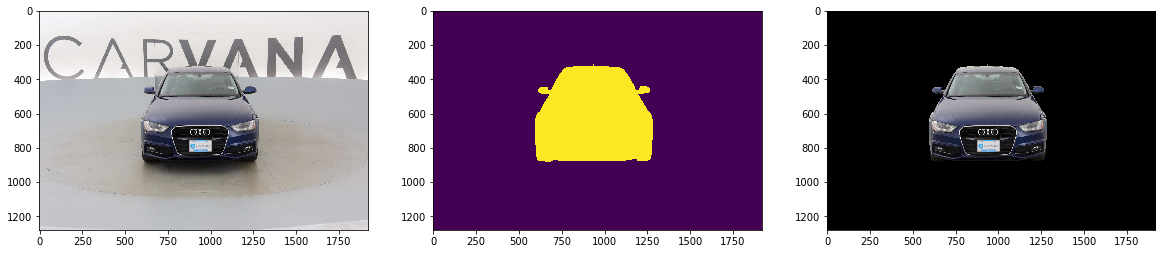

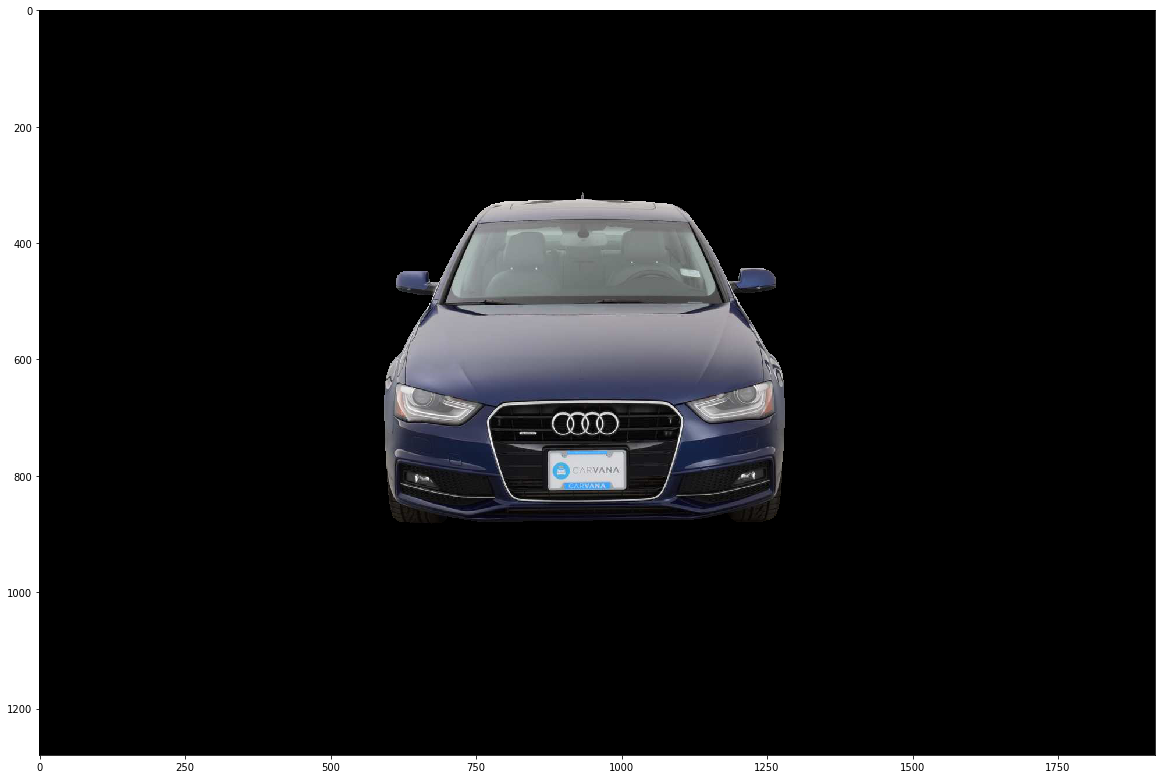

In [6]:
plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
img = get_image_data("0cdf5b5d0ce1_01", "Train")
print(img.shape)
plt.imshow(img)

plt.subplot(1, 3, 2)
mask = get_image_data("0cdf5b5d0ce1_01", "Train_mask")
print(mask.shape)
plt.imshow(mask)

plt.subplot(1, 3, 3)
masked = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(masked)

# print(masked)
plt.figure(figsize=(20,20))
plt.imshow(masked)

In [7]:
TRAIN_MASKS_CSV = pd.read_csv("data/train_masks.csv")
TRAIN_MASKS_CSV["location"] = "data/train/" + TRAIN_MASKS_CSV["img"]

METADATA_CSV = pd.read_csv("data/metadata.csv")

In [8]:
TRAIN_MASKS_CSV.head()

,img,rle_mask,location
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...,data/train/00087a6bd4dc_01.jpg
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...,data/train/00087a6bd4dc_02.jpg
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...,data/train/00087a6bd4dc_03.jpg
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...,data/train/00087a6bd4dc_04.jpg
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...,data/train/00087a6bd4dc_05.jpg


In [9]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

(1280, 1918)


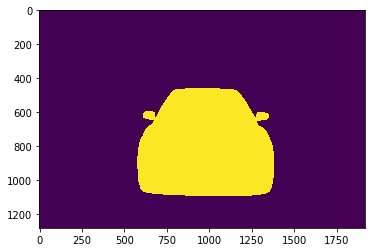

In [10]:
def getRLETruth(image_name):
    df = TRAIN_MASKS_CSV[TRAIN_MASKS_CSV["img"] == image_name]
    rle_mask = df["rle_mask"].values[0]
    mask = rle_decode(rle_mask, (1280, 1918))
    return mask

mask = getRLETruth("00087a6bd4dc_01.jpg")
# (1280, 1918)
print(mask.shape)
plt.imshow(mask)

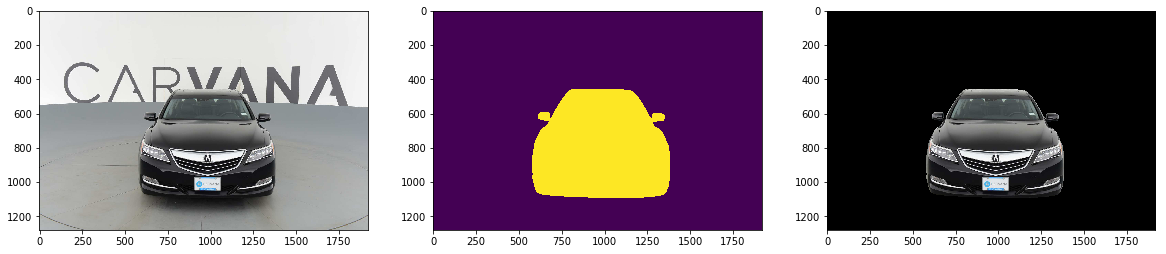

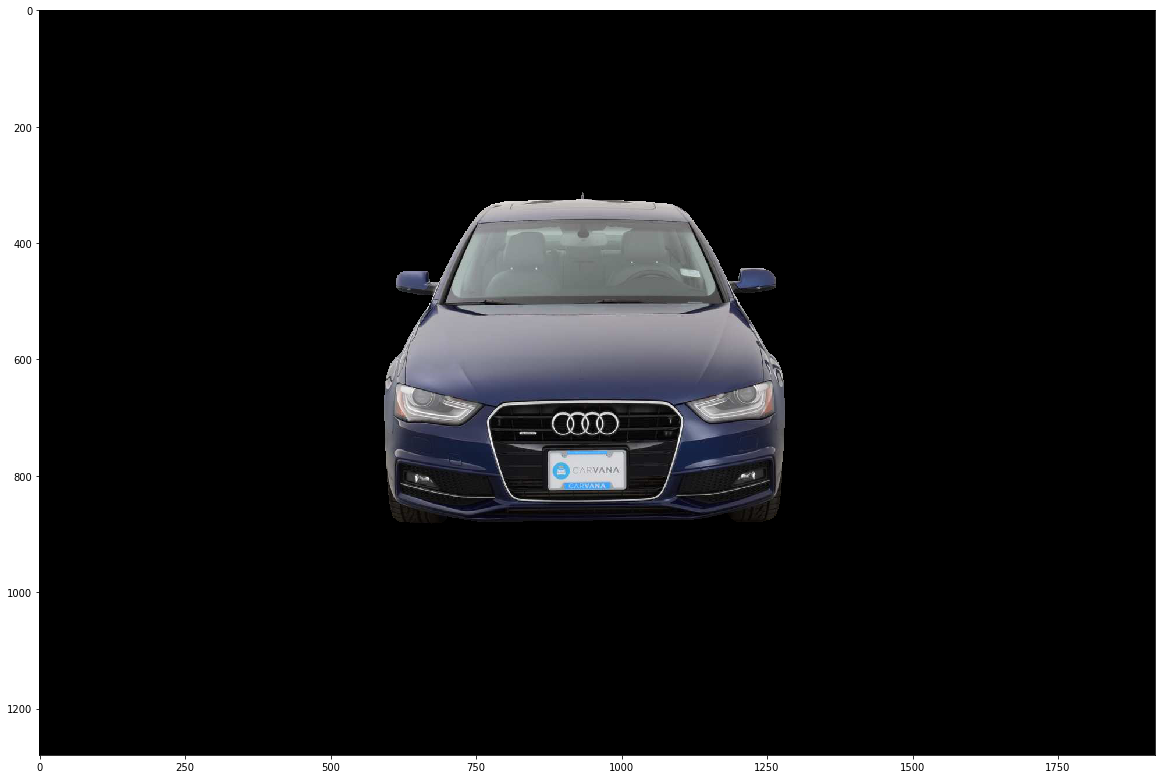

In [11]:
def plot_images(img, mask):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.subplot(1, 3, 3)
    masked = cv2.bitwise_and(img, img, mask=mask)
    plt.imshow(masked)

img = get_image_data("00087a6bd4dc_01", "Train")
mask = getRLETruth("00087a6bd4dc_01.jpg")

plot_images(img, mask)
# print(masked)
plt.figure(figsize=(20,20))
plt.imshow(masked)

In [12]:
TRAIN_MASKS_CSV.head()

,img,rle_mask,location
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...,data/train/00087a6bd4dc_01.jpg
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...,data/train/00087a6bd4dc_02.jpg
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...,data/train/00087a6bd4dc_03.jpg
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...,data/train/00087a6bd4dc_04.jpg
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...,data/train/00087a6bd4dc_05.jpg


In [13]:
# shuffled = TRAIN_MASKS_CSV.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(TRAIN_MASKS_CSV, test_size=0.3)

print(len(df_train))
print(len(df_test))
df_train.head()

3561
1527


,img,rle_mask,location
2402,6d375bc2ece1_03.jpg,781723 14 783638 19 785554 21 787470 24 789181...,data/train/6d375bc2ece1_03.jpg
2799,85bc655a7523_16.jpg,558962 3 560880 3 562798 3 564716 3 566634 3 5...,data/train/85bc655a7523_16.jpg
2070,630335e37f40_07.jpg,511596 12 513508 19 515421 25 517335 29 519250...,data/train/630335e37f40_07.jpg
3485,b1a27da4f01c_14.jpg,875169 7 877078 23 878993 30 880910 34 881052 ...,data/train/b1a27da4f01c_14.jpg
1393,3f202616a2b9_02.jpg,618481 103 620367 157 622257 202 624156 238 62...,data/train/3f202616a2b9_02.jpg


In [173]:
# Need to save the df_train and df_test to file

df_test.to_csv("df_test.csv")
df_train.to_csv("df_train.csv")

In [177]:
# Load the df_train and df_test from file
df_train = pd.read_csv("df_train.csv", index_col=0)
df_test = pd.read_csv("df_test.csv", index_col=0)
df_train.head()

,img,rle_mask,location
2402,6d375bc2ece1_03.jpg,781723 14 783638 19 785554 21 787470 24 789181...,data/train/6d375bc2ece1_03.jpg
2799,85bc655a7523_16.jpg,558962 3 560880 3 562798 3 564716 3 566634 3 5...,data/train/85bc655a7523_16.jpg
2070,630335e37f40_07.jpg,511596 12 513508 19 515421 25 517335 29 519250...,data/train/630335e37f40_07.jpg
3485,b1a27da4f01c_14.jpg,875169 7 877078 23 878993 30 880910 34 881052 ...,data/train/b1a27da4f01c_14.jpg
1393,3f202616a2b9_02.jpg,618481 103 620367 157 622257 202 624156 238 62...,data/train/3f202616a2b9_02.jpg


In [14]:
# Testing padding
a = np.arange(9)
a = a.reshape(3, 3, 1)

# print(a)
# print(a.shape)
a = np.pad(a, [(0, 0), (1,1), (0, 0)], 'constant', constant_values=(0, 0))
# print(a.shape)
# print(a)

In [178]:
def generator(df, batch_size=1):
    while 1:
        x_sample = []
        y_sample = []
        for i in range(batch_size):
            item = randint(0,df.shape[0]-1)
            row = df.iloc[item]
            img = cv2.imread(row.location)
            img = np.pad(img, [(0, 0), (1,1), (0, 0)], 'constant', constant_values=(0, 0))
            x = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            y = rle_decode(row.rle_mask,(1280,1918))
            y = np.pad(y, [(0, 0), (1,1)], 'constant', constant_values=(0, 0))
            y = np.expand_dims(y, axis=2)
            x_sample.append(x)
            y_sample.append(y)
        yield np.stack(x_sample), np.stack(y_sample)
        
test_generator = generator(df_test)
train_generator = generator(df_train)

(1, 1280, 1920, 3)
(1, 1280, 1920, 1)
(1280, 1920)


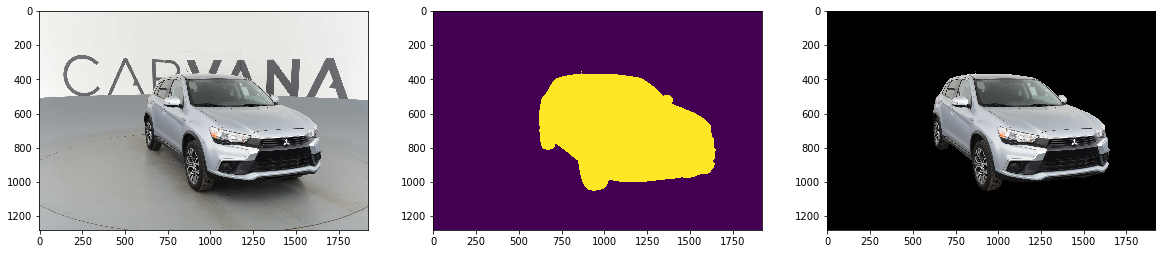

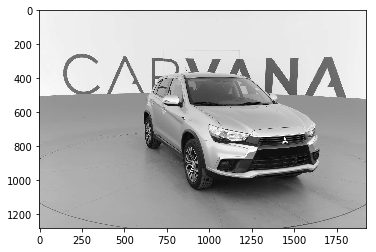

In [186]:
x, y = next(train_generator)

print(x.shape)
print(y.shape)

index = 0
plot_images(x[index], np.squeeze(y[index], axis=2))

# print(type(x[0][0][0][0]))

# 0.299 R + 0.587 G + 0.114 B 
gray = 0.299*x[0][:, :, 0] + 0.587*x[0][:, :, 1] + 0.114*x[0][:, :, 2]
print(gray.shape)
# gray = tf.image.rgb_to_grayscale(x[0])
plt.figure()
plt.imshow(gray, cmap='gray')

# Tensorflow - UNet

In [180]:
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.core import Activation
from keras.layers import Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.layers.advanced_activations import ThresholdedReLU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import tensorflow as tf

In [216]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = y_pred + threshold_shift

    tp = K.sum(y_true * y_pred_bin) + K.epsilon()
    fp = K.sum(K.clip(y_pred_bin - y_true, 0, 1))
    fn = K.sum(K.clip(y_true - y_pred, 0, 1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

def fbeta_loss(y_true, y_pred):
    return -fbeta(y_true, y_pred)


def conv2D(inputs, kernels=16, kernelSize=(3,3), name=None, padding='same'):
    conv = Convolution2D(kernels, (kernelSize[0], 1), padding=padding, name=(name+"_3x1"))(inputs)
    conv = Convolution2D(kernels, (1, kernelSize[1]), padding=padding, name=(name+"_1x3"))(conv)
#     conv = BatchNormalization()(conv)
    conv = Activation('selu')(conv)
    return conv

# def convertToGray(x):
#     x = 0.299*x[:, :, :, 0] + 0.587*x[:, :, :, 1] + 0.114*x[:, :, :, 2]
#     x = K.expand_dims(x, axis=3)
#     return x

# (1280, 1918)
def getModel():
    inputs = Input((1280, 1920, 3))
#     gray = Lambda(convertToGray)(inputs)
#     gray_normalized = Lambda(lambda x: (x / 255.0) - 0.5)(gray)
    
    preproc = Lambda(lambda x: (x / 255.0) - 0.5)(inputs)
    conv1 = conv2D(preproc, kernels=16, name='conv1_1')
    conv1 = conv2D(conv1, kernels=16, name='conv1_2')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv2D(pool1, kernels=32, name='conv2_1')
    conv2 = conv2D(conv2, kernels=32, name='conv2_2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv2D(pool2, kernels=48, name='conv3_1')
    conv3 = conv2D(conv3, kernels=48, name='conv3_2')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv2D(pool3, kernels=64, name='conv4_1')
    conv4 = conv2D(conv4, kernels=64, name='conv4_2')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv2D(pool4, kernels=80, name='conv5_1')
    conv5 = conv2D(conv5, kernels=80, name='conv5_2')
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    conv6 = conv2D(pool5, kernels=96, name='conv6_1')
    conv6 = conv2D(conv6, kernels=96, name='conv6_2')
#     pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)

    up5 = Concatenate()([UpSampling2D(size=(2,2))(conv6), conv5])
    upconv5 = conv2D(up5, kernels=80, name='upconv5_1')
    upconv5 = conv2D(upconv5, kernels=64, name='upconv5_2')

    up4 = Concatenate()([UpSampling2D(size=(2,2))(upconv5), conv4])
    upconv4 = conv2D(up4, kernels=64, name='upconv4_1')
    upconv4 = conv2D(upconv4, kernels=64, name='upconv4_2')
    
    up3 = Concatenate()([UpSampling2D(size=(2,2))(upconv4), conv3])
    upconv3 = conv2D(up3, kernels=48, name='upconv3_1')
    upconv3 = conv2D(upconv3, kernels=48, name='upconv3_2')
    
    up2 = Concatenate()([UpSampling2D(size=(2,2))(upconv3), conv2])
    upconv2 = conv2D(up2, kernels=32, name='upconv2_1')
    upconv2 = conv2D(upconv2, kernels=32, name='upconv2_2')
    
    up1 = Concatenate()([UpSampling2D(size=(2,2))(upconv2), conv1, preproc])
    upconv1 = conv2D(up1, kernels=16, name='upconv1_1')
    upconv1 = conv2D(upconv1, kernels=16, name='upconv1_2')
    
    upconv1 = Convolution2D(1, (1, 1), activation='sigmoid')(upconv1)
#     upconv1 = Convolution2D(1, (1, 1), activation='sigmoid')(upconv1)
#     upconv1 = Convolution2D(1, (1, 1))(upconv2)
#     upconv1 = ThresholdedReLU(theta=0.90)(upconv1)
#     upconv1 = Activation("selu")(upconv1)
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-2)
    model = Model(inputs=inputs, outputs=upconv1)
    
#     model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=adam, loss=fbeta_loss, metrics=[fbeta])
    return model


model = getModel()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_49 (InputLayer)            (None, 1280, 1920, 3) 0                                            
____________________________________________________________________________________________________
lambda_51 (Lambda)               (None, 1280, 1920, 3) 0           input_49[0][0]                   
____________________________________________________________________________________________________
conv1_1_3x1 (Conv2D)             (None, 1280, 1920, 16 160         lambda_51[0][0]                  
____________________________________________________________________________________________________
conv1_1_1x3 (Conv2D)             (None, 1280, 1920, 16 784         conv1_1_3x1[0][0]                
___________________________________________________________________________________________

In [121]:
model.load_weights("UNet_weights2-1.h5")

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=300, verbose=2)
model.save("UNet2-1.h5")
model.save_weights("UNet_weights2-1.h5", overwrite=True)

Epoch 1/300
99s - loss: -7.4124e-01 - fbeta: 0.7412
Epoch 2/300
94s - loss: -8.5721e-01 - fbeta: 0.8572
Epoch 3/300
94s - loss: -8.8763e-01 - fbeta: 0.8876
Epoch 4/300
94s - loss: -9.1192e-01 - fbeta: 0.9119
Epoch 5/300
94s - loss: -9.2961e-01 - fbeta: 0.9296
Epoch 6/300
94s - loss: -9.2903e-01 - fbeta: 0.9290
Epoch 7/300
93s - loss: -9.2637e-01 - fbeta: 0.9264
Epoch 8/300
93s - loss: -9.3677e-01 - fbeta: 0.9368
Epoch 9/300
93s - loss: -9.3768e-01 - fbeta: 0.9377
Epoch 10/300
93s - loss: -9.3678e-01 - fbeta: 0.9368
Epoch 11/300
93s - loss: -9.4272e-01 - fbeta: 0.9427
Epoch 12/300
93s - loss: -9.4706e-01 - fbeta: 0.9471
Epoch 13/300
93s - loss: -9.4532e-01 - fbeta: 0.9453
Epoch 14/300
93s - loss: -9.4719e-01 - fbeta: 0.9472
Epoch 15/300
94s - loss: -9.5112e-01 - fbeta: 0.9511
Epoch 16/300
93s - loss: -9.5059e-01 - fbeta: 0.9506
Epoch 17/300
92s - loss: -9.4814e-01 - fbeta: 0.9481
Epoch 18/300
93s - loss: -9.4934e-01 - fbeta: 0.9493
Epoch 19/300
92s - loss: -9.5466e-01 - fbeta: 0.9547
Ep

Model 1
```
# first run
100*500 = 50000
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
Epoch 100/500
83s - loss: -9.9226e-01 - dice_coef: 0.9923
Epoch 500/500
81s - loss: -9.9588e-01 - dice_coef: 0.9959

# second run
100*300 = 50000
adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-2)
Epoch 300/300
82s - loss: -9.9626e-01 - dice_coef: 0.9963

```

Model 2
```

```


dict_keys(['dice_coef', 'loss'])


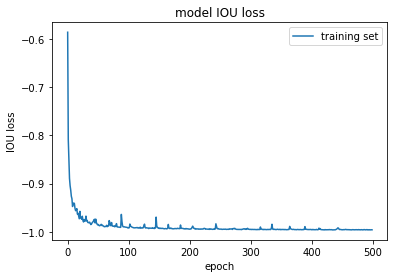

In [108]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model IOU loss')
plt.ylabel('IOU loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [100]:
### Save weights 
model.save("UNet-2.h5")
model.save_weights("UNet_weights-2.h5", overwrite=True)

In [89]:
model.load_weights("UNet_weights.h5")

CPU times: user 216 ms, sys: 52 ms, total: 268 ms
Wall time: 235 ms


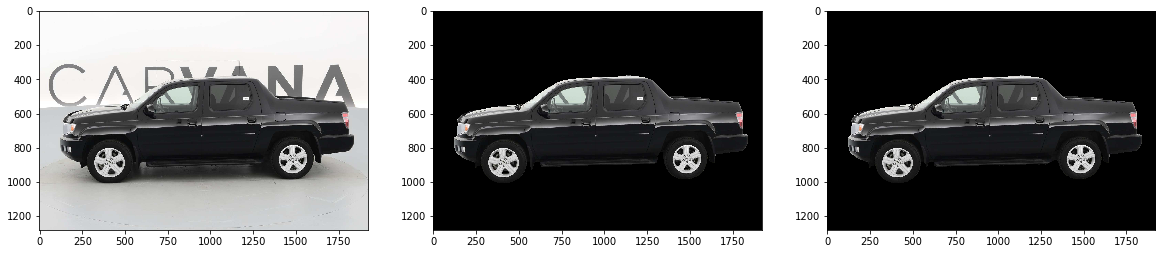

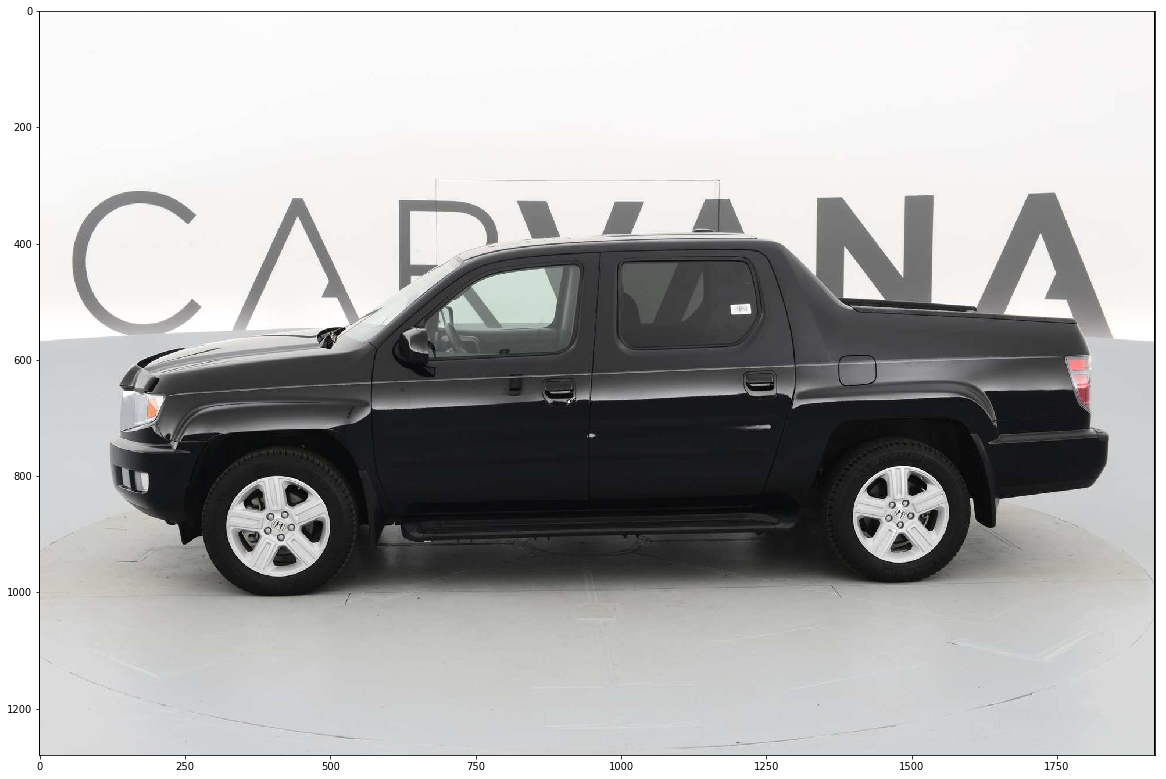

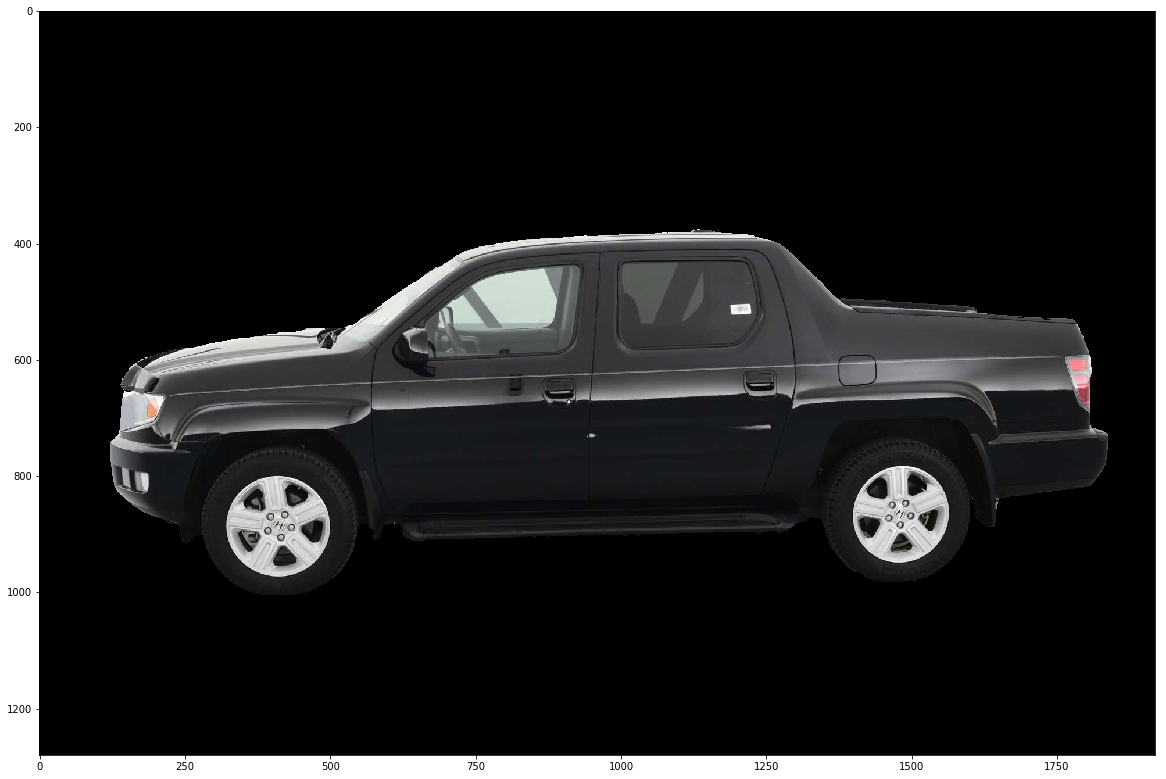

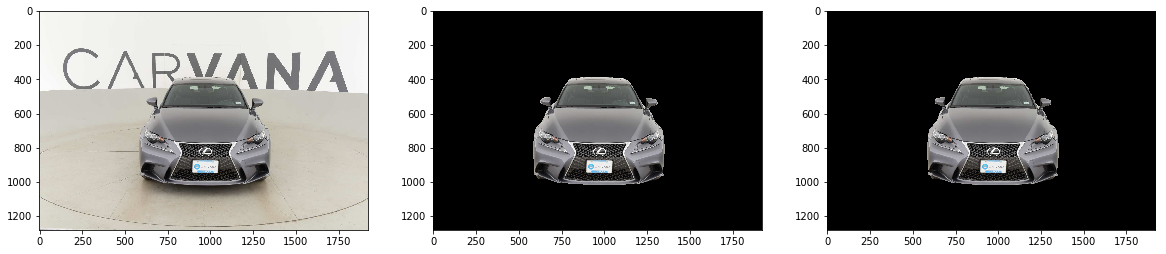

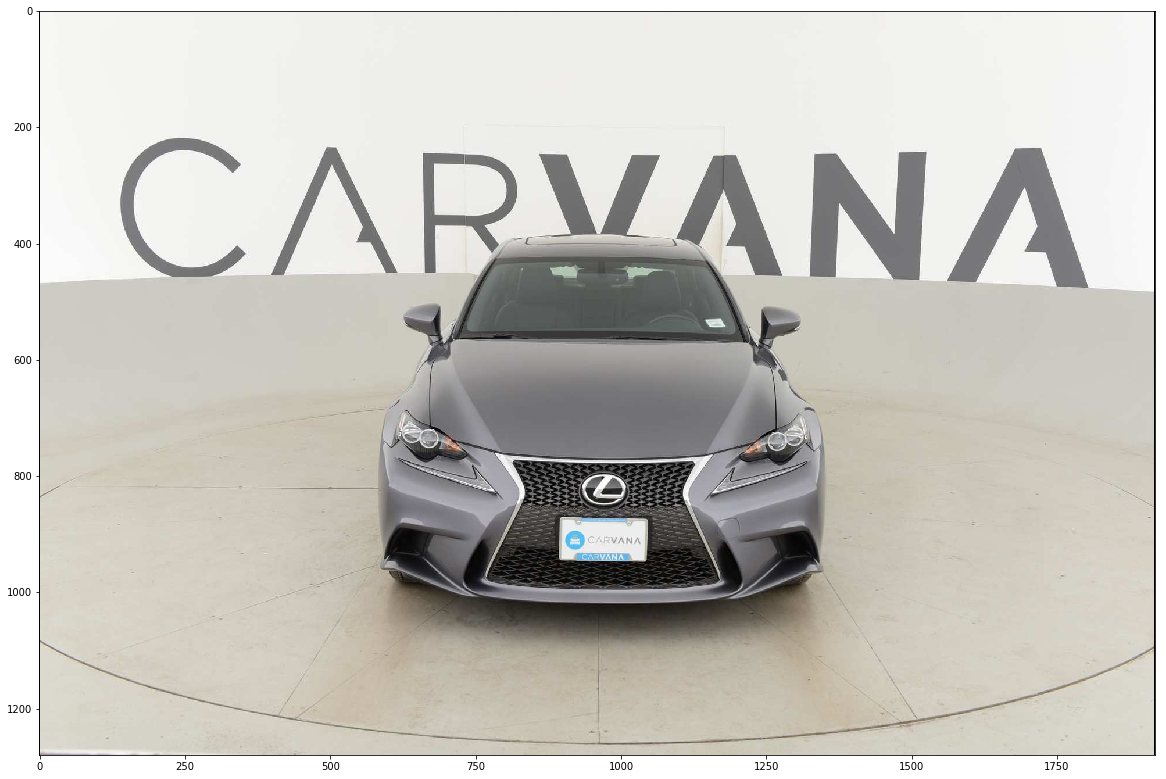

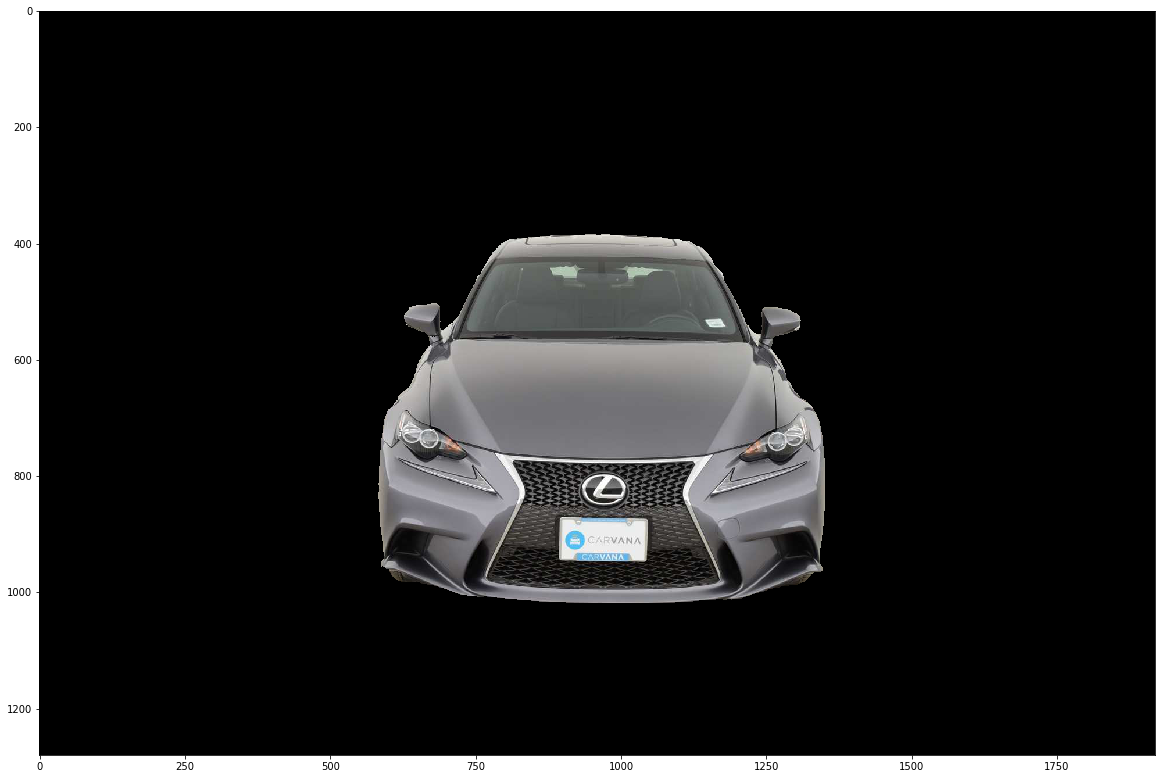

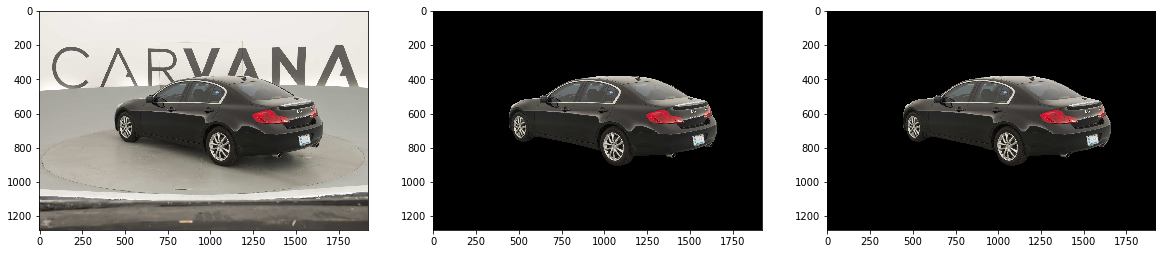

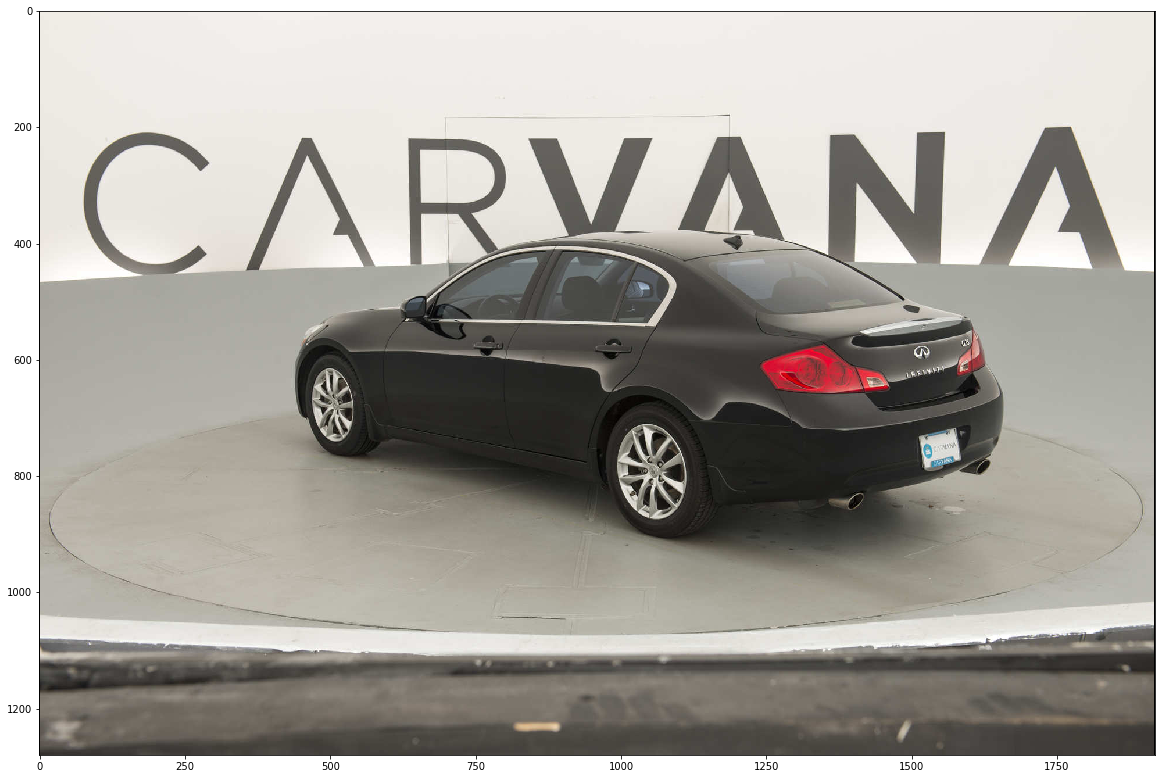

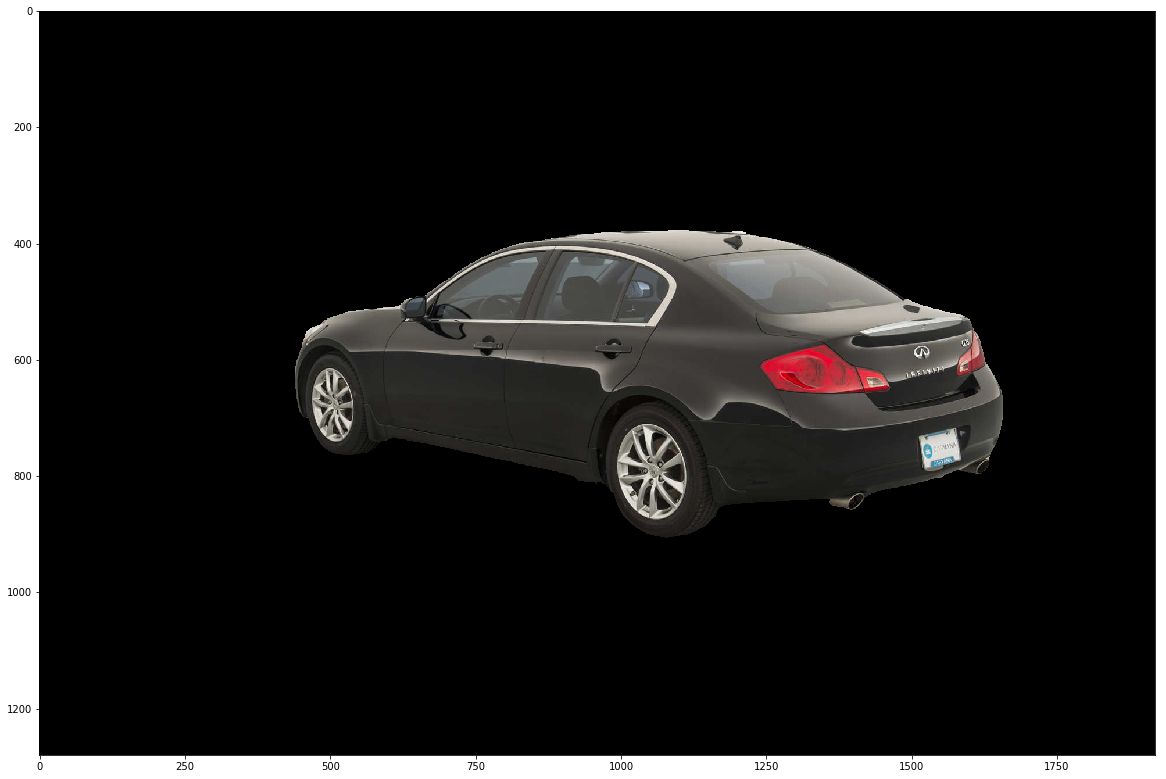

In [130]:
x, y = next(train_generator)
def show_result(x, y, prediction):
    z = x[0].copy()
    z[prediction.squeeze()<0.5]=0
    
    plt.figure(figsize=(20,20))
    plt.subplot(1, 3, 1)
    plt.imshow(x[0])
    plt.subplot(1, 3, 2)
    masked = cv2.bitwise_and(x[0], x[0], mask=y[0].squeeze())
    plt.imshow(masked)
    plt.subplot(1, 3, 3)
    plt.imshow(z)
    #show bigger images
    plt.figure(figsize=(20,20))
    plt.imshow(x[0])
    plt.figure(figsize=(20,20))
    plt.imshow(z)

%time prediction = model.predict(x)[0]
show_result(x, y, prediction)

x, y = next(test_generator)
prediction = model.predict(x)[0]
show_result(x, y, prediction)

x, y = next(test_generator)
prediction = model.predict(x)[0]
show_result(x, y, prediction)

# plot_images(img=z, mask=mask)
# plt.imshow(prediction.squeeze())

2.0.0
